In [1]:
import pandas as pd

In [2]:
%run data_cleaning.ipynb
%run data_exploration.ipynb

## Data Visualization

In [3]:
import numpy as np
from plotnine import *
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib as mpl

import matplotlib.dates as mdates
import datetime

%matplotlib inline
warnings.filterwarnings("ignore")

#### a. bar plot

In [4]:
barplot = combined_dataset.groupby(["out_airline_company", "arr_city"]).size().reset_index(name="N")
barplot

,out_airline_company,arr_city,N
0,Lufthansa,GRU,636
1,Lufthansa,JFK,434
2,Swiss,GRU,518
3,Swiss,JFK,854


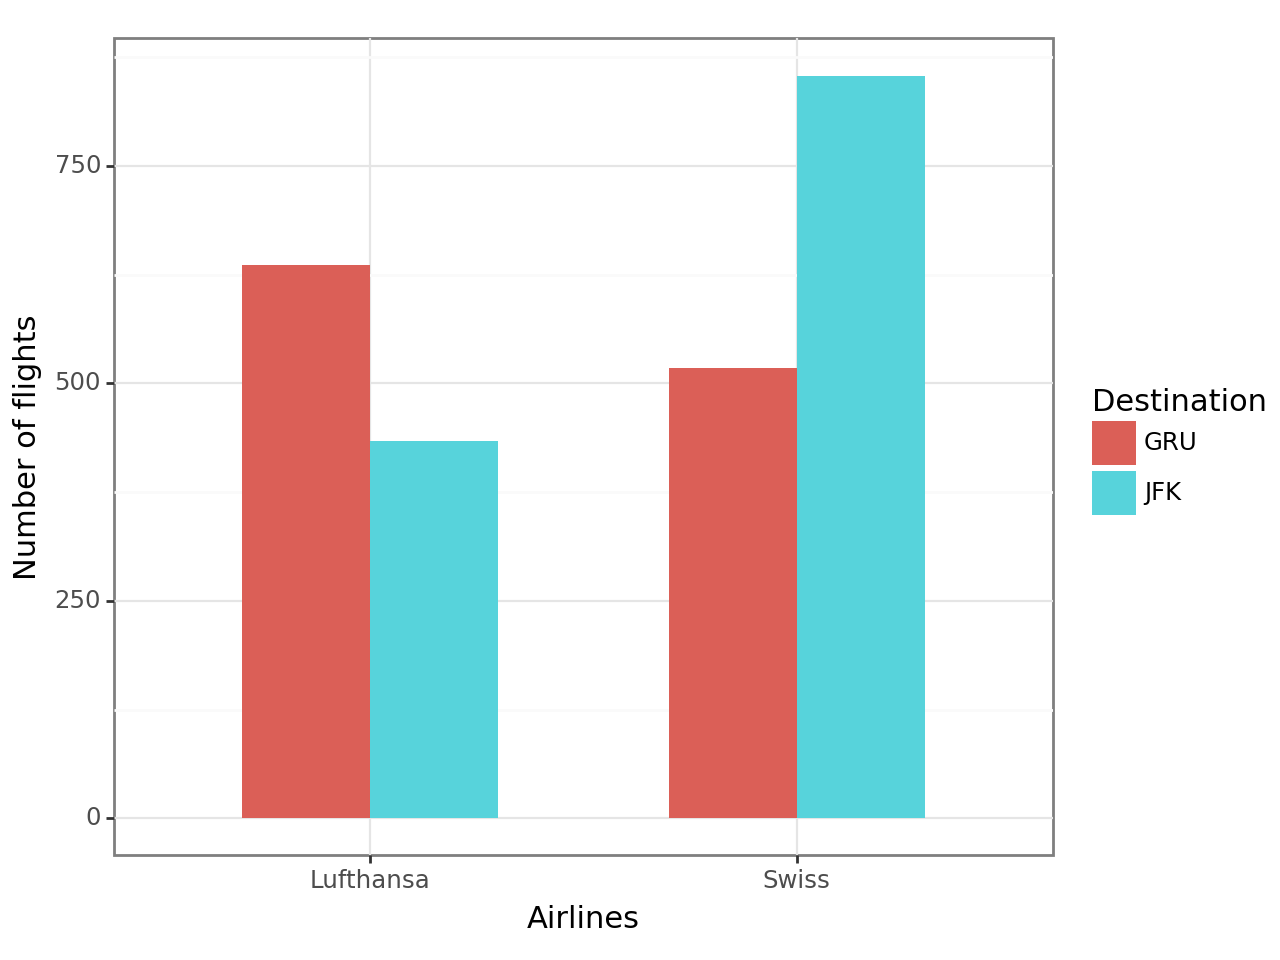

<Figure Size: (640 x 480)>

In [5]:
f1 = (
    ggplot(barplot, aes(x="out_airline_company", y="N", fill="arr_city"))
    + geom_bar(stat="identity", position="dodge", width=0.6, size=0.5)
    + labs(x="Airlines", y="Number of flights", fill="Destination")
    + theme_bw()
    
)
f1